# Fast Matrix Factorization for Restaurant Recommendation

Hu, Leyi (UIN: 825006858)&nbsp;&nbsp;&nbsp;
Li, Xiangyu (UIN: 325005816)&nbsp;&nbsp;&nbsp;
Liu, Fangshuo (UIN:524007836)&nbsp;&nbsp;&nbsp;
Xie, Mindong (UIN:623008993)

### 1. Introduction and Problem Statement
Nowadays, there are various of APPs in our daily life, trying to do recommendations such as movies, restaurants, traveling plans and hotels to their users. However, many users are not satisfied with the accuracy of the recommendation. In order to improve users’ experience and satisfaction, companies have considered many factors like locations, popularity and time. Lots of research has been done to optimize the result. One of the challenges is the high sparsity of unobserved feedback, where most existing works tried to assign a uniform weight to the missing data to reduce time complexity. However, in real world, this uniform assumption is invalid and inflexible. Besides, current MF models usually have an issue with time complexity, which makes them unsuitable on large data. Therefore, we try to address these two issues by introducing a new learning algorithm based on the element-wise Alternating Least Squares (eALS) algorithm, optimizing a MF model with variably-weighted missing data.


### 2. Related Works
Due to the lack of negative feedback, it is necessary to handle missing data for learning from implicit data. As we know, there are two strategies which have been proposed: sample based learning and whole-data based learning. Sample-based learning, which samples negative instances from missing data, is more efficient while the model’s predictiveness is decreased. Whole-based learning, which is a little inefficient, has a higher coverage. We will use whole-based learning to retain our model’s reliability.

For existing whole-based learning, the main issue is that using uniform weighting on missing data limits model’s flexibility and extensibility. Pan$^{[1]}$ is the only one who has considered non-uniform weighting, while the cubic time complexity is unsuitable to run on large-scale data. Alternating Least Square (ALS) is a popular method to optimize MF. The sub-problem of optimization is solved by Hu’s work$^{[2]}$. Even after optimization, ALS is still unsuitable for running on large data. And the uniform weighting assumption is invalid in real world either. Another related method is generic element-wise ALS learner$^{[3]}$. Instead of lying in the matrix inversion operation, generic element-wise ALS learner optimized parameters at the element level and reduced the time complexity.


#### Reference:

[1]. R. Pan and M. Scholz. Mind the gaps: Weighting the unknown in large-scale one-class collaborative filtering. In KDD 2009, pages 667–676.

[2]. Y. Hu, Y. Koren, and C. Volinsky. Collaborative filtering for implicit feedback datasets. In ICDM 2008, pages 263–272.

[3]. S. Rendle, Z. Gantner, C. Freudenthaler, and L. Schmidt-Thieme. Fast context-aware recommendations with factorization machines. In SIGIR 2011, pages 635–644.

[4]. Paper: Fast Matrix Factorization for Online Recommendation with Implicit Feedback

### 3. Approach / Methods
#### 3.1 Data Preprocessing
We used the data of Yelp Dataset Challenge. The json file of Yelp Review data has more than 4 million reviews. We transformed the review dataset into implicit data, where each entry is marked as 0/1 indicating whether the user reviewed the restaurant, because it shows the relationship between users and restaurants they’ve visited.

Yelp Review data

https://drive.google.com/open?id=0B9TG6qvQTwaub1dpNFZsejc2V3c

At first, we realized the algorithm and tried it on a tiny dataset of 100,000 reviews. Since the high sparsity of the original datasets makes it difficult to evaluate recommendation algorithms (e.g., over half users have only one review), we wanted to filter out users and items with less than 10 interactions. We constructed the original user-restaurant matrix and then deleted users of less than 10 interactions with restaurants and restaurants of less than 10 interactions with users once for each. Then we got a 755\*115 matrix.

We picked the first interaction between user and restaurant of each user in the matrix as our test set, and the rest was training set. But the matrix was too sparse, there's no way to keep 10 interactions for both user-to-restaurant and restaurant-to-user. This led to a really low accuracy of nearly 0 of the resulting recommendations.

So the problem was that we couldn't use a dataset that is too tiny. We wanted to use a huge dataset trying to improve accuracy. However, after taking the possible memory deficiency into consideration, we chose to pick 1 million reviews, which was a relatively large but not too resource-exhausting dataset. The original user-restaurant matrix was 430000\*55000. We cut the first 80000 rows to do the rest work in order to avoid memory error. After we filtered out users and items with less than 15 interactions, we got a 805\*705 matrix as our input for the algorithm. Unfortunately, the accuracy was still not good enough.

We thought that the reason might be that we didn't consider users' recent interest in restaurants. Practically, I used to love Mexican food, but I may love Japanese food now. This factor might strongly affect the results. So we then used timestamp to choose test set by picking out each user's latest interaction with restaurants for prediction, considering users' recent interest in the types of restaurants. The models are trained on the remaining data. This time the resulting recommendation was quite good.

In [2]:
# DATA PREPROCESSING PART, DO NOT RUN!
# construct users' dictionary and restaurants' dictionary by extracting users and restaurants from review doc
import json
import numpy as np

user = {}
item = {}
i=0
j=0
for line in open('data_1m.json','r'):
    review = json.loads(line)
    if review["user_id"] not in user:
        user[review["user_id"]]=i
        i+=1
    if review["business_id"] not in item:
        item[review["business_id"]]=j
        j+=1

print len(user)
print len(item)

437672
55117


In [ ]:
# DATA PREPROCESSING PART, DO NOT RUN!
# construct two matrices with the dimensions of # of users and # of restaurants
# one matrix is for time of user-restaurant interactions
# the other matrix is 0/1 indicating whether the user reviewed the restaurant
import time
import datetime
import numpy as np

rR = np.zeros((len(user),len(item),))
r01 = np.zeros((len(user),len(item),))

for line in open('data_1m.json','r'):
    review = json.loads(line)
    tm = time.mktime(datetime.datetime.strptime(review["date"], "%Y-%m-%d").timetuple())
    rR[user[review["user_id"]]][item[review["business_id"]]]=tm
    r01[user[review["user_id"]]][item[review["business_id"]]]=1

We chose the first 80,000 rows for the remaining work. In case of memory error, we split the data into 4 parts, and merged them back together after processing separately.

In [ ]:
# extract first 80,000 rows for processing
# for memory limitation, save four matrices, each one has 20,000 rows
rtm1 = []
r101=[]
rtm2 = []
r201=[]
rtm3 = []
r301=[]
rtm4 = []
r401=[]
for i in range(20000):
    rtm1.append(rR[i])
    r101.append(r01[i])
for i in range(20000):
    rtm2.append(rR[i+20000])
    r201.append(r01[i+20000])
for i in range(20000):
    rtm3.append(rR[i+40000])
    r301.append(r01[i+40000])
for i in range(20000):
    rtm4.append(rR[i+60000])
    r401.append(r01[i+60000])

In [ ]:
np.save("rtm1.npy",rtm1)
np.save("filter_1m_01_1.npy",r101)
np.save("rtm2.npy",rtm2)
np.save("filter_1m_01_2.npy",r201)
np.save("rtm3.npy",rtm3)
np.save("filter_1m_01_3.npy",r301)
np.save("filter_1m_01_3.npy",r301)
np.save("rtm4.npy",rtm4)
np.save("filter_1m_01_4.npy",r401)

In [2]:
# DATA PREPROCESSING PART, DO NOT RUN!

import numpy as np
# filter out row with <= n in matrix(timestamp)
# for conlumn, transpose matrix
def deleteM2R(n,matrixR,matrix01):
    output = []
    # current axis position
    i = 0 
    while(i < len(matrix01)):
        if np.sum(matrix01[i]) >= n:
        #To delete the i row, do this:
            output.append(matrixR[i])
        i += 1
    return output

def deleteM201(n,matrix01):
    output = []
    # current axis position
    i = 0 
    while(i < len(matrix01)):
        if np.sum(matrix01[i]) >= n:
        #To delete the i row, do this:
            output.append(matrix01[i])
        i += 1
    return output

In [ ]:
# DATA PREPROCESSING PART, DO NOT RUN!

rtm1 = np.load("rtm1.npy")
r01 = np.load("filter_1m_01_1.npy")
rtm2 = np.load("rtm2.npy")
r02 = np.load("filter_1m_01_2.npy")
rtm3 = np.load("rtm3.npy")
r03 = np.load("filter_1m_01_3.npy")
rtm4 = np.load("rtm4.npy")
r04 = np.load("filter_1m_01_4.npy")

In [ ]:
# filter out users with more than 15 restaurant, DO NOT RUN!
f_rtm1 = deleteM2R(15,rtm1,r01)
f_r01 = deleteM201(15,r01)
np.save("f_rtm1.npy", f_rtm1)
np.save("f_r01.npy", f_r01)
f_rtm2 = deleteM2R(15,rtm2,r02)
f_r02 = deleteM201(15,r02)
np.save("f_rtm2.npy", f_rtm2)
np.save("f_r02.npy", f_r02)
f_rtm3 = deleteM2R(15,rtm3,r03)
f_r03 = deleteM201(15,r03)
np.save("f_rtm3.npy", f_rtm3)
np.save("f_r03.npy", f_r03)
f_rtm4 = deleteM2R(15,rtm4,r04)
f_r04 = deleteM201(15,r04)
np.save("f_rtm4.npy", f_rtm4)
np.save("f_r04.npy", f_r04)

In [ ]:
# combine the 4 filtered matrix 
f_rtm1 = np.load("f_rtm1.npy")
f_r01 = np.load("f_r01.npy")
f_rtm2 = np.load("f_rtm2.npy")
f_r02 = np.load("f_r02.npy")
f_rtm3 = np.load("f_rtm3.npy")
f_r03 = np.load("f_r03.npy")
f_rtm4 = np.load("f_rtm4.npy")
f_r04 = np.load("f_r04.npy")

r10R = np.concatenate((f_rtm1,f_rtm2,f_rtm3,f_rtm4),axis=0)
r1001 = np.concatenate((f_r01,f_r02,f_r03,f_r04),axis=0)

In [ ]:
# DATA PREPROCESSING PART, DO NOT RUN!
# keep transpose and delete until the # of row and columns does not change

arr10R = np.asarray(r10R)
t10R = arr10R.transpose()
arr1001 = np.asarray(r1001)
t1001 = arr1001.transpose()

# filter out items(or users) with less 15 users(or items)
r10R = deleteM2R(15,t10R,t1001)
r1001 = deleteM201(15,t1001)
print len(r10R)
print len(r10R[0])

In [ ]:
# save the final matrix that will be used as input of algorithm
np.save("1m_15_time",r10R)
np.save("1m_15_01_new", r1001)

#### 3.2 Algorithm 
Instead of applying a simple uniform weight on missing entries, we believe it is more realistic to weight missing data based on some item property. All other factors being equal, popular items are more likely to be known by users in general. So we think that a miss on a popular item is more probable to be truly irrelevant to the user. Thus, we define a parameter C and parametrize C[i] based on item's popularity: $c_i=c_0\frac{f_i^\alpha}{\sum_{j=1}^N f_j^\alpha}$

The objective function here is L=L1-L2+L3
$$L_1=\sum_{(u,i)\in R}w_{ui}(r_{ui}-\hat{r}_{ui})^2$$
$$L_2=\sum_{u=1}^M\sum_{i\not\in R_u}c_i\hat{r}_{ui}^2$$
$$L_3=\lambda(\sum_{u=1}^M||{\bf p}_u||^2+\sum_{i=1}^N||{\bf q}_i||^2)$$
L1 represents the error between the real user-item value and the one we predict; L2 represents the popularity-aware weighting of missing data; and L3 is the regularization. 

Here we use the Fast eALS Learning Algorithm to resolve the problem. Unlike the traditional ALS, we speed up learning by optimizing parameters at the element level, avoiding the massive repeated computations of the whole matrix which are introduced by the weighted missing data. And also, there are some unnecessarily repeated computations when we update the latent factors for different users. We can achieve a significant speed-up by memorizing it. So we define 2 caches Sq and Sp, which can be pre-computed and used for all users. You can see the details in the code below.  

In [1]:
# objective function: L=L1-L2+L3  
def L(P,Q,R):
    sumP = 0
    for Pi in P:
        sumP += np.square(Pi)
    sumP = np.sum(sumP)
    sumQ = 0
    for Qi in Q:
        sumQ += np.square(Qi)
    sumQ = np.sum(sumQ)
    L1 = 0
    L2 = 0
    for i in range(len(r1101)):
        for j in range(len(r1101[i])):
            if r1101[i][j]>0:
                L1 += W[i][j]*(r1101[i][j]-R[i][j])**2
            elif (r1101[i][j]) == 0:
                L2 += c[j]*(R[i][j])**2
    L3 = lamda*(sumP+sumQ)
    return L1 - L2 + L3




In [2]:
# 2 caches for the speeding up. 
def getSq(c,Q):
    Sq = np.zeros((len(Q[0]),len(Q[0])))
    for i in range(len(Q)):
        Sq += c[i] * Q[i].T * Q[i]
    return Sq

${\bf S}^q=\sum_{i=1}^N c_i {\bf q}_i {\bf q}_i^T$

In [3]:
def getSp(P):
    Sp = np.dot(P.T,P)
    return Sp

${\bf S}^p={\bf P}^T {\bf P}$

In [4]:
# using fast eALS Algorithm to compute

#by updating puf and qif every time, we can update P and Q and thus R(R=P*QT)
# get the puf by setting the derivative of the objective function(with respect to puf) to zero. 
def getPuf(Rf,Q,P,Sq,u,f):
    f1 = 0
    f2 = 0
    f3 = 0
#  for i in range(len(Rf[0])):
    for i in lr[u]:
        f1 += (W[u][i] * r1101[u][i] - (W[u][i] - c[i]) * Rf[u][i]) * Q[i][f]
        f2 += (W[u][i] - c[i]) * (Q[i][f])**2
    for ki in range(k):
        if ki != f:
            f3 += P[u][ki] * Sq[ki][f]
    puf = (f1 - f3) * 1.0 /(f2 + Sq[f][f] + lamda)
    return puf

$p_{uf}=\frac{\sum_{i\in R_u}[w_{ui}r_{ui}-(w_{ui}-c_i)\hat{r}_{ui}^f]q_{if}-\sum_{k\neq f}p_{uk}s_{kf}^q}{\sum_{i\in R_u}(w_{ui}-c_i)q_{if}^2+s_{ff}^q+\lambda}$

In [5]:
# similarly, get the qif
def getQif(Rf,Q,P,Sp,i,f):
    f1 = 0
    f2 = 0
    f3 = 0
#   for u in range(len(Rf)):
    for u in lru[i]:
        f1 += (W[u][i] * r1101[u][i] - (W[u][i] - c[i]) * Rf[u][i]) * P[u][f]
        f2 += (W[u][i] - c[i]) * (P[u][f])**2
    for ki in range(k):
        if ki != f:
            f3 += Q[i][ki] * Sp[ki][f]
    qif = (f1 - c[i] * f3) * 1.0 /(f2 + c[i] * Sp[f][f] + lamda)
    return qif

$q_{if}=\frac{\sum_{u\in R_i}[w_{ui}r_{ui}-(w_{ui}-c_i)\hat{r}_{ui}^f]p_{uf}-c_i\sum_{k\neq f}q_{ik}s_{kf}^p}{\sum_{u\in R_i}(w_{ui}-c_i)p_{uf}^2+c_i s_{ff}^p+\lambda}$

In [6]:
#while result of the objective function is not the smallest, keep doing the loops below
def uploop(L1,P,Q,R):
    z=0  #loop times 
    Rf = np.zeros((len(R),len(R[0])))
    #delta is the difference between two adjacent objective function values
    delta = 1000
    while (delta >=0.1 and z < 50):
        #update user factors 
        Sq = getSq(c,Q)
        for u in range(len(R)):
            for f in range(k):
                for i in lr[u]: 
                    #updating Rf[u][i] 
                    Rf[u][i] = R[u][i] - P[u][f]*Q[i][f]
                P[u][f] = getPuf(Rf,Q,P,Sq,u,f)
        #  for i in range(len(R[0])):
                for i in lr[u]:
                    R[u][i] = Rf[u][i] + P[u][f]*Q[i][f]
        # update item factors
        Sp = getSp(P)
        for i in range(len(R[0])):
            for f in range(k):
                #  for u in range(len(R)):
                for u in lru[i]:
                    Rf[u][i] = R[u][i] - P[u][f]*Q[i][f]
                Q[i][f] = getQif(Rf,Q,P,Sp,i,f)
                for u in lru[i]:
                    R[u][i] = Rf[u][i] + P[u][f]*Q[i][f]
        L2 = L(P,Q,R)
        delta = L1-L2
        L1 = L2   
        z += 1
    print "z = ",z
    return P,Q

#### 3.3 Testing
The eALS algorithm's efficiency has been proved in the paper, compared with the traditional ALS and RCD. In order to test the algorithm's accuracy, here we choose the latest user-item pair of value 1 at each row to do the test, considering it is the most current reflection of users' preference. 

First extracting those user-item pairs we need to test and removing them from the matrix. Then applying the eALS Algorithm to the objective function L, making predictions according to users' previous actions. If eventually the item could be among the specific user's recommendations, then we would think the algorithm to be successful. By recording those successful ones, we can get the approximate accuracy of the algorithm. 

In [7]:
import operator
from itertools import islice
def tst():
    ranked = []
    rankedV = []
    for i in range(len(R)):
        rn = sorted(range(len(R[i])), key=lambda j:R[i][j],reverse = True)
        rnv = sorted(range(len(R[i])), reverse = True)    
        ranked.append(list(islice(rn,5+dvd + np.sum(r1101[i]))))
        rankedV.append(list(islice(rnv,5+dvd + np.sum(r1101[i]))))
    count = 0
    for i in range(len(test01)):
        for j in range(len(test01[0])):
            if test01[i][j] > 0:
                if (j in ranked[i]):
                    count += 1
    accuracy = count * 1.0 / (len(R)*dvd)
    print "accuracy=",accuracy
    return accuracy

In [8]:
import json
import numpy as np   
lst = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
llst = [0,1,2,3,4,5,6,7,8,9,10]
lllst = [5,6,7,8,9,10,11]
last = [0.1,0.01,0.001,0.0001,0.00001]
 
dvd = 1
i_mu = 0
i_stv = 0.01

# user-restaurant data of 805 * 705 matrix we get 
r11R = np.load("1m_15_time.npy")
r1101 = np.load("1m_15_01_new.npy")
testR = np.zeros((len(r11R),len(r11R[0])))
test01 = np.zeros((len(r11R),len(r11R[0])))
 
for i in range(len(r1101)):
    rn = sorted(range(len(r11R[i])), key=lambda j:r11R[i][j],reverse = True)
    rnv = sorted(r11R[i],reverse = True)
    for j in range(dvd):
    # d is the current num of test value
        test01[i][rn[j]] = 1
        testR[i][rn[j]] = r11R[i][rn[j]]
        r1101[i][rn[j]] = -1
        r11R[i][rn[j]] = -1
        
# list of item in users
lr = [0]*len(r1101)
for i in range(len(r1101)):
    lr[i] = []
    for j in range(len(r1101[0])):
        if r1101[i][j]>0:
            lr[i].append(j)
            
# list of user in items
lru = [0]*len(r1101[0])
for j in range(len(r1101[0])):
    lru[j] = []
    for i in range(len(r1101)):
        if r1101[i][j]>0:
            lru[j].append(i)
            
# W matrix
W = r1101
t1101 = r1101.transpose()

k = 8
P_rand = np.random.normal(i_mu,i_stv,(len(r1101),k))
Q_rand = np.random.normal(i_mu,i_stv,(len(r1101[0]),k))
R0 = np.dot(P_rand,Q_rand.T)

### 4.  Experiment and Evaluation
The experiment part is focused on the adjusting the parameters including alpha, lambda and c0. As the alpha and c0 are more important for the accuracy, and lambda is for formulation regulation, we first optimize the alpha and c0 based on the test accuracy. After that, we optimize the lambda. The optimization process is that we use two loops to test all the combinations of alpha and c0 so that we could get the optimized accuracy.

The accuracy is defined as hit-ratio. It means that when the system recommended the top 10 highest scores based on the prediction, if the tested restaurant is included, the count is incremented 1. Then the hit-ratio is defined as the total count divided by the total user.
The typical accuracy for our implementation is 22.7%, which is a high accuracy using only the implicit data comparing with random baseline with 3.8% accuracy.


In [21]:
result = np.empty([11, 11])
# l = []
# for e in range(11):
for e in llst:
    for j in llst:
    # parameters    
        lamda = 0.001
    #         lamda = 0
        c0 = 256
        c0 = 2**e
    #     alpha = 0.1**6
        alpha = 0.1*j

        c = []
        s = 0
        for i in r1101:
            s += (np.sum(i))**alpha
            #     print "s = ",s
        for i in r1101:
            ci = c0 * (np.sum(i))**alpha * 1.0 / s
            c.append(ci)
        P = P_rand
        Q = Q_rand
        R = R0
            #     print "R.max=",R.max()
                # stoppong criteria
        L1 = L(P,Q,R)
        res = uploop(L1,P,Q,R)
        R = np.dot(res[0],res[1].T)
            #     print len(R),len(R[0])
            #     print R
#         print lamda
        print "c0 = ",c0
        print "alpha = ",alpha
#         l.append(tst())
        result[e][j] = tst()

z =  50
c0 =  1
alpha =  0.0
accuracy= 0.157763975155
z =  50
c0 =  1
alpha =  0.1
accuracy= 0.152795031056
z =  50
c0 =  1
alpha =  0.2
accuracy= 0.136645962733
z =  50
c0 =  1
alpha =  0.3
accuracy= 0.132919254658
z =  1
c0 =  1
alpha =  0.4
accuracy= 0.130434782609
z =  1
c0 =  1
alpha =  0.5
accuracy= 0.127950310559
z =  1
c0 =  1
alpha =  0.6
accuracy= 0.130434782609
z =  1
c0 =  1
alpha =  0.7
accuracy= 0.129192546584
z =  1
c0 =  1
alpha =  0.8
accuracy= 0.132919254658
z =  1
c0 =  1
alpha =  0.9
accuracy= 0.135403726708
z =  1
c0 =  1
alpha =  1.0
accuracy= 0.135403726708
z =  1
c0 =  2
alpha =  0.0
accuracy= 0.150310559006
z =  1
c0 =  2
alpha =  0.1
accuracy= 0.150310559006
z =  1
c0 =  2
alpha =  0.2
accuracy= 0.155279503106
z =  1
c0 =  2
alpha =  0.3
accuracy= 0.152795031056
z =  1
c0 =  2
alpha =  0.4
accuracy= 0.154037267081
z =  1
c0 =  2
alpha =  0.5
accuracy= 0.151552795031
z =  1
c0 =  2
alpha =  0.6
accuracy= 0.147826086957
z =  1
c0 =  2
alpha =  0.7
accuracy= 0.15

In [22]:
np.save("testResult0001.npy", result)

In order to evaluate the implementation does increase the accuracy, we set up a random baseline, which means that the random recommendation’s hit ratio. it shows that the accuracy is only 3.8%.

In [13]:
# random baseline
r1101 = np.load("1m_15_01.npy")

numer = np.sum(r1101)+dvd*len(r1101)
denom = len(r1101) * len(r1101[0])
base = numer*1.0/denom
print base
# print R[0]

0.038884630633


##### The first belowplot shows that when lambda = 0.001, alpha = 0.2, the relations between c0 and accuracy. The plot shows accuracy is optimized when c0 =512.

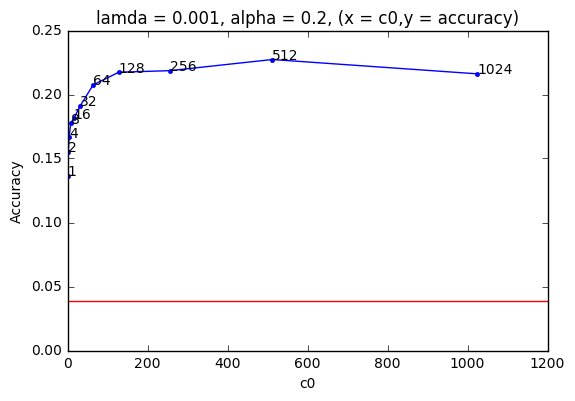

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
# chart: lamda = 0, alpha = 0.6, (x = c0,y = accuracy)
x1 = []
y1 = []
for i in range(11):
    x1.append(2**i)
    y1.append(result[i][2])

fig1 = plt.figure()
rect = 0.1,0.1,0.8,0.8
axes1 = fig1.add_axes(rect)
axes1.plot(x1,y1,'b.-')
axes1.axhline(y=base,xmin=0,xmax=3,c="r",linewidth=1)
axes1.set_xlabel('c0') 
axes1.set_ylabel('Accuracy')
axes1.set_title('lamda = 0.001, alpha = 0.2, (x = c0,y = accuracy)')
for i, x in enumerate(x1):
    axes1.annotate(x,(x1[i],y1[i]))
    


##### The second plot below shows that when lambda = 0.001, c0 = 512, the relations between alpha and accuracy. The plot shows accuracy is optimized when alpha = 0.2.

[0.22484472049689441, 0.2236024844720497, 0.22732919254658385, 0.22111801242236026, 0.2186335403726708, 0.20869565217391303, 0.20248447204968945, 0.1937888198757764, 0.1937888198757764, 0.18509316770186335, 0.18757763975155278]


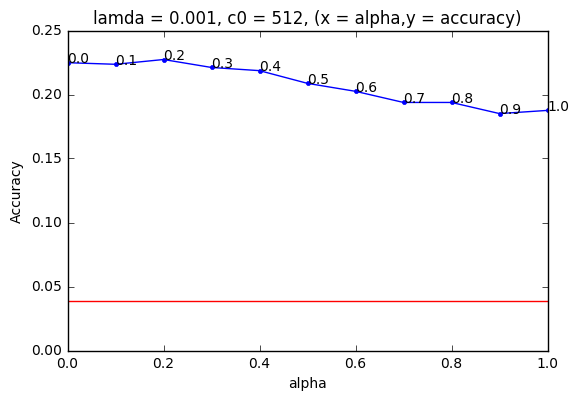

In [24]:
# chart: lamda = 0, c0 = 256, (x = alpha,y = accuracy)
x2 = []
y2 = []
for j in range(11):
    x2.append(0.1*j)
    y2.append(result[9][j])
    
print y2

fig2 = plt.figure()
rect = 0.1,0.1,0.8,0.8
axes2 = fig2.add_axes(rect)
axes2.plot(x2,y2,'b.-')
axes2.axhline(y=base,xmin=0,xmax=3,c="r",linewidth=1)
axes2.set_xlabel('alpha') 
axes2.set_ylabel('Accuracy')
axes2.set_title('lamda = 0.001, c0 = 512, (x = alpha,y = accuracy)')
for i, x in enumerate(x2):
    axes2.annotate(x,(x2[i],y2[i]))

### 5.  Conclusion

In this project, we studied the problem of learning MF models from implicit feedback using the Yelp review dataset. Previously, people applied a uniform weight on missing data, while we weighted missing data based on the popularity of restaurants. In order to solve the key efficiency problem, we reimplemented a new algorithm - eALS - which optimize parameters at the element level — optimizing each coordinate of the latent vector. The result with our dataset shows an accuracy of 22.7% comparing to the random baseline 3%. After the implementation of the project, we learnt a more practical way to use MF for implicit data. First, eALS algorithm can easily incorporate prior domain knowledge. Second, we can see that this algorithm is attractive for large-scale industrial deployment. 

Currently, we successfully reimplemented the element-wise ALS algorithm in its basic MF form and solved the time efficiency problem. In the next step, to make the eALS more practical to real-world, we will take side information into consideration, such like user social contexts and reviews, to extend eALS to more generic models, such as collective factorization and factorization machines.
